<a href="https://colab.research.google.com/github/gerardgoh/bt4222/blob/main/reviews_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing of 5-core Amazon Reviews
This notebook is used for the cleaning of the raw review dataset. The output of this is 2 csv files, which would be used for the following purposes:

(1) reviews_for_rag.csv - RAG explanation pipeline, and

(2) reviews_for_neuMF.csv - user-item interaction matrix for the NeuMF pipeline.

In [ ]:
!pip install tiktoken

In [ ]:
import re
import html
import pandas as pd
import gzip
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tiktoken

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/amazon_data"

cleaned_reviews.csv	  qa_Electronics.json.gz	 reviews_for_neumf.csv
meta_Electronics.json.gz  reviews_Electronics_5.json.gz  reviews_for_rag.csv


In [ ]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

file_path = "/content/drive/My Drive/amazon_data/reviews_Electronics_5.json.gz"
print("Loading data from", file_path)
reviews_original = getDF(file_path)
reviews = reviews_original.copy() # make a copy of the data

Loading data from /content/drive/My Drive/amazon_data/reviews_Electronics_5.json.gz


# Exploring the Data

In [ ]:
print(reviews.head(10))
print(reviews.info())

       reviewerID        asin                           reviewerName  \
0   AO94DHGC771SJ  0528881469                                amazdnu   
1   AMO214LNFCEI4  0528881469                        Amazon Customer   
2  A3N7T0DY83Y4IG  0528881469                          C. A. Freeman   
3  A1H8PY3QHMQQA0  0528881469               Dave M. Shaw "mack dave"   
4  A24EV6RXELQZ63  0528881469                            Wayne Smith   
5  A2JXAZZI9PHK9Z  0594451647          Billy G. Noland "Bill Noland"   
6  A2P5U7BDKKT7FW  0594451647                              Christian   
7   AAZ084UMH8VZ2  0594451647  D. L. Brown "A Knower Of Good Things"   
8   AEZ3CR6BKIROJ  0594451647                           Mark Dietter   
9  A3BY5KCNQZXV5U  0594451647                                Matenai   

    helpful                                         reviewText  overall  \
0    [0, 0]  We got this GPS for my husband who is an (OTR)...      5.0   
1  [12, 15]  I'm a professional OTR truck driver, and I b

Checking for duplicates

In [ ]:
reviews.duplicated(subset=['reviewerID', 'asin', 'reviewText']).sum()

np.int64(0)

Drop unwanted columns

In [ ]:
reviews = reviews.drop(columns=['reviewerName','reviewTime'] )

## Distribution of Reviews and Reviewers

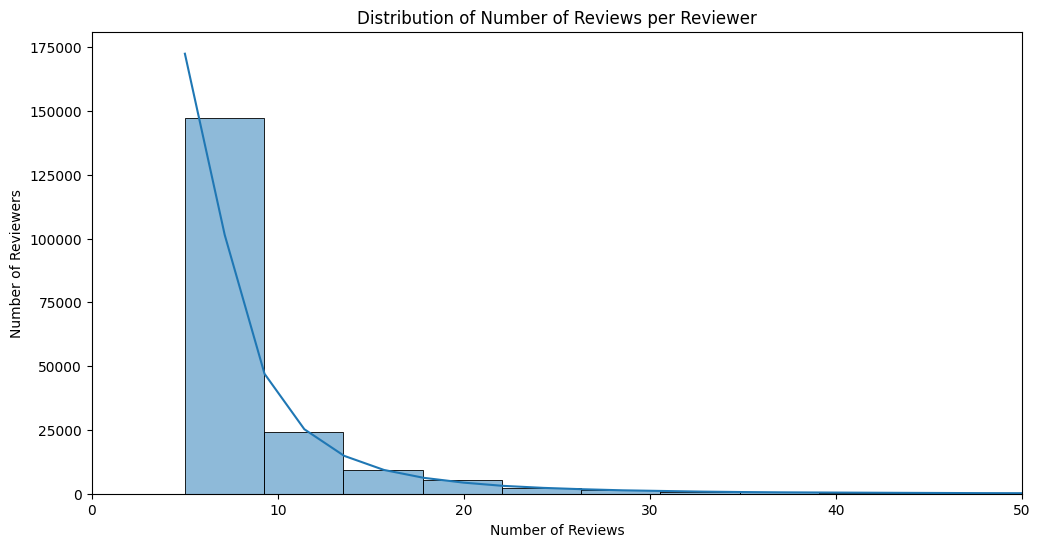

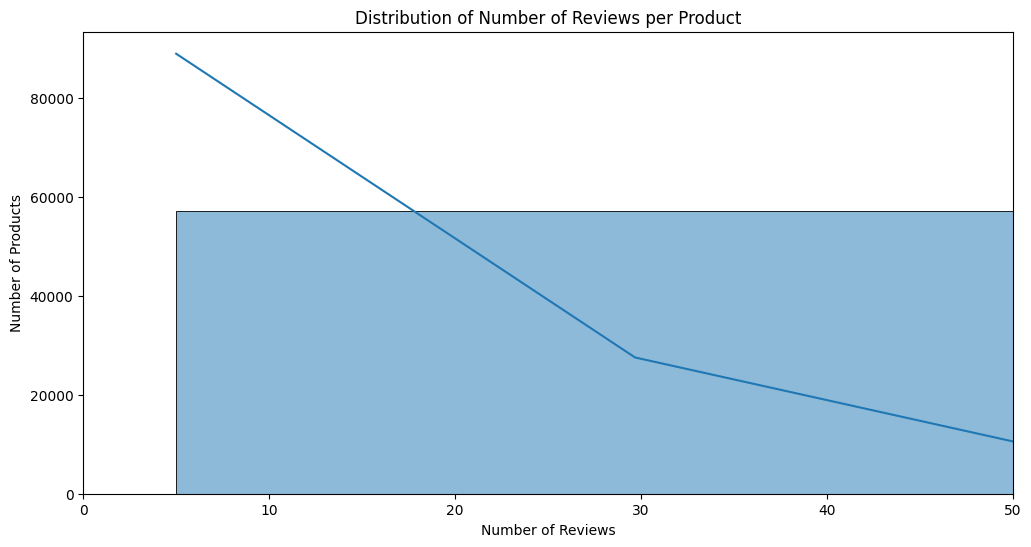

In [ ]:
# Number of Reviews per reviewer
reviews_per_user = reviews.groupby('reviewerID').size()

# Number of Reviews per product
reviews_per_product = reviews.groupby('asin').size()

# Plot Reviews per reviewer
plt.figure(figsize=(12, 6))
sns.histplot(reviews_per_user, bins=100, kde=True)
plt.title('Distribution of Number of Reviews per Reviewer')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Reviewers')
plt.xlim(0, 50)  # Optional: zoom in if there are outliers
plt.show()

# Plot Reviews per product
plt.figure(figsize=(12, 6))
sns.histplot(reviews_per_product, bins=100, kde=True)
plt.title('Distribution of Number of Reviews per Product')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Products')
plt.xlim(0, 50)  # Optional: zoom in if there are outliers
plt.show()

From the plots, we validate that:
- All reviewers reviewed at least 5 products
- All products have at least 5 reviews

Thus, the datasets are dense enough and is suitable for further downstream tasks.

## Creating a Helpfulness Score
This section focuses on creating a new feature to quantify the helpfulness of reviews, which can be used by the RAG to retrieve the most relevant reviews into the prompt.

In [ ]:
reviews['helpfulRatio'] = reviews['helpful'].apply(
    lambda x: x[0]/x[1] if x[1] > 0 else 0
)

From the histogram, we observe that a majority of reviews have a helpful ratio  close to 0. This is likely because most reviews were never voted on, not necessarily because they are bad reviews. As a result, raw helpfulness alone is not a reliable signal — many reviews simply don't have enough votes.

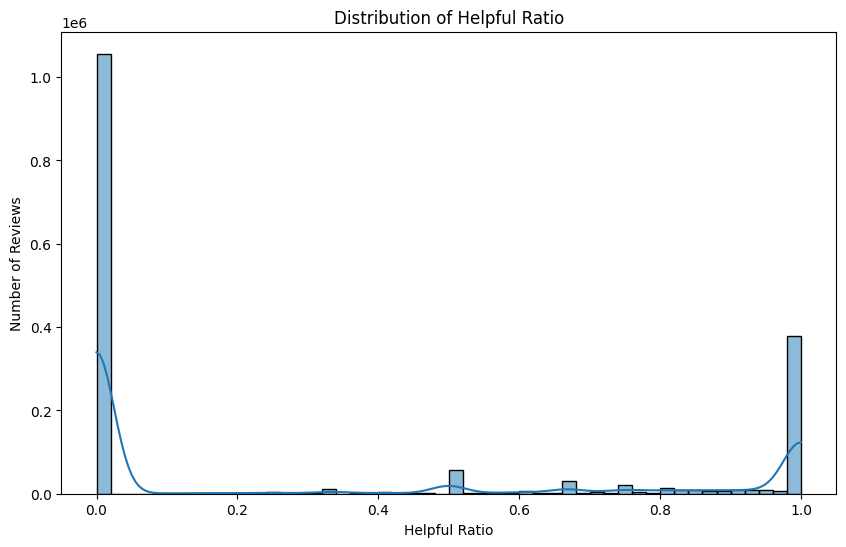

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(reviews['helpfulRatio'], bins=50, kde=True)
plt.title('Distribution of Helpful Ratio')
plt.xlabel('Helpful Ratio')
plt.ylabel('Number of Reviews')
plt.show()

We recognise that helpfulRatio may be misleading. A review with 1/1 helpful votes would score 1.0, but a review with 95/100 votes (0.95) is actually more reliable due to the larger sample size.

Hence, we feature engineer a weighted score that gives more weight depending on the sample size. We also apply a log transformation to dampen the effect of an overly high vote count and clip the weight at 1 to maintain the same 0-1 scale.


In [ ]:
reviews['weighted_helpfulness'] = reviews.apply(
    lambda x: x['helpfulRatio'] * min(1, np.log1p(x['helpful'][1])/5)
    if x['helpful'][1] > 0 else 0, axis=1
)

The histogram shows that the majority of reviews have low weighted helpfulness scores. This suggests that while there are many reviews, only a small fraction of them are perceived as genuinely helpful by a significant number of users.

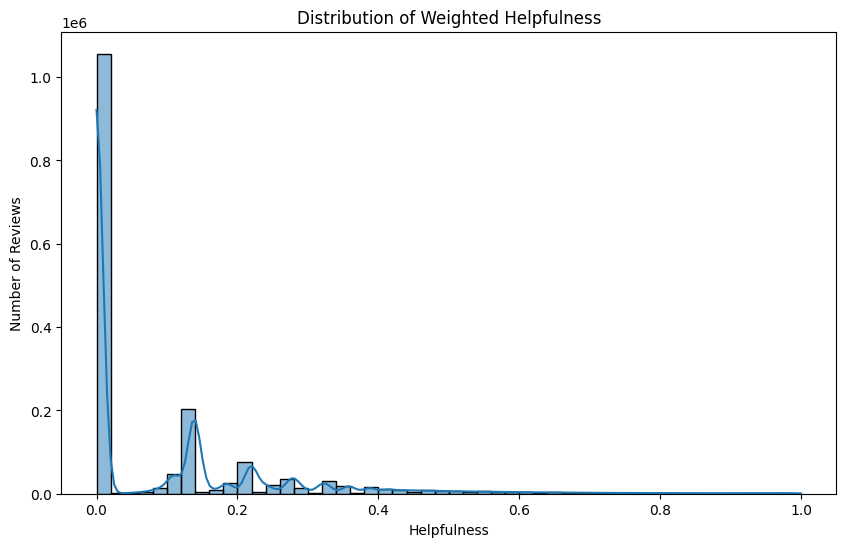

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(reviews['weighted_helpfulness'], bins=50, kde=True)
plt.title('Distribution of Weighted Helpfulness')
plt.xlabel('Helpfulness')
plt.ylabel('Number of Reviews')
plt.show()

However, even among helpful reviews, older reviews may no longer accurately reflect the current state of the product, especially in fast-evolving categories like electronics where products are frequently updated.

To address this, we introduce a recency factor, giving slight preference to more recent reviews. When combining both, helpfulness remains the dominant factor but recency boosts newer reviews in the ranking.

In [ ]:
max_time = reviews['unixReviewTime'].max()
min_time = reviews['unixReviewTime'].min()
reviews['recency'] = (reviews['unixReviewTime'] - min_time) / (max_time - min_time)

reviews['combined_score'] = (
    0.8 * reviews['weighted_helpfulness'] +
    0.2 * reviews['recency']
)

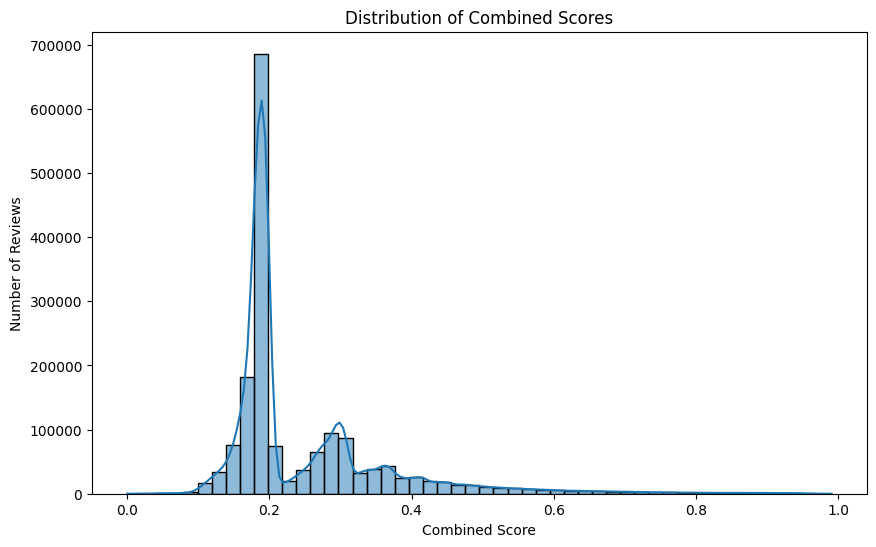

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(reviews['combined_score'], bins=50, kde=True)
plt.title('Distribution of Combined Scores')
plt.xlabel('Combined Score')
plt.ylabel('Number of Reviews')
plt.show()

From the distribution, most reviews sitll have relatively low scores. This indicates that while the combined score is useful for ranking, it is not strong enough to distinguish truly relevant reviews on its own.

To truly surface relevant reviews, we embed the reviews and perform semantic similarity matching, using meaning as the primary filter. We will use combined scores as a secondary filter to slightly prioritize better reviews but not solely relying on it for retrieval.

# Processing Text Features

In [ ]:
print(reviews['reviewText'])

0          We got this GPS for my husband who is an (OTR)...
1          I'm a professional OTR truck driver, and I bou...
2          Well, what can I say.  I've had this unit in m...
3          Not going to write a long review, even thought...
4          I've had mine for a year and here's what we go...
                                 ...                        
1689183    Burned these in before listening to them for a...
1689184    Some people like DJ style headphones or earbud...
1689185    I&#8217;m a big fan of the Brainwavz S1 (actua...
1689186    I've used theBrainwavz S1 In Ear Headphones, a...
1689187    Normally when I receive a review sample I can ...
Name: reviewText, Length: 1689188, dtype: object


From a quick browsing of the review data, we noticed a few inconsistencies that need to be addressed before using the reviews in our RAG pipeline:

1. Many reviews contain HTML entities (like \&#34; for quotation marks and &\#8217; for apostrophes) that need to be decoded for proper readability.
2. There are issues with excessive whitespace, particularly large amounts of leading spaces that cause the text to display poorly when printed.
3. Some reviews have formatting quirks like line breaks or special characters that don't add value to the review content.
4. A small portion of reviews contain disclaimer statements indicating the reviewer received the product as a free sample (e.g., "Sample provided for review"). These do not provide useful information and will be removed.

Traditional NLP processing steps like stemming and lemmatisation will not be performed to keep the natural language intact for the LLM to process effectively.

In [ ]:
def clean_review_text(text):
    if not isinstance(text, str):
        return ""

    # Decode HTML entitiesa
    text = html.unescape(text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove excessive whitespace (including at the beginning)
    text = re.sub(r'^\s+', '', text)  # Remove leading whitespace
    text = re.sub(r'\s+', ' ', text).strip()  # Replace multiple spaces with single space

    # Optional: Remove review disclaimer statements
    text = re.sub(r'I was provided a sample (in exchange for|for) (a|an) .*review\.?', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\[Sample provided for review\]', '', text)
    text = re.sub(r'--Sample provided--.*', '', text)

    return text

In [ ]:
reviews['clean_reviewText'] = reviews['reviewText'].apply(clean_review_text)
reviews['clean_summary'] = reviews['summary'].apply(clean_review_text)

## Truncating Reviews

In our RAG system, we will pass relevant reviews into Open AI GPT model to generate explanations. To optimise token usage, we will truncate the reviews before embedding and retrieval.

We believe that truncating balances token usage and information preservation, as important content is typically concentrated at the beginning of reviews, and the separate "summary" field already captures the review's main idea.

In [ ]:
# Measure review length by number of characters
reviews['review_length'] = reviews['clean_reviewText'].apply(lambda x: len(str(x)))

# Measure review length by number of words
reviews['word_count'] = reviews['clean_reviewText'].apply(lambda x: len(str(x).split()))

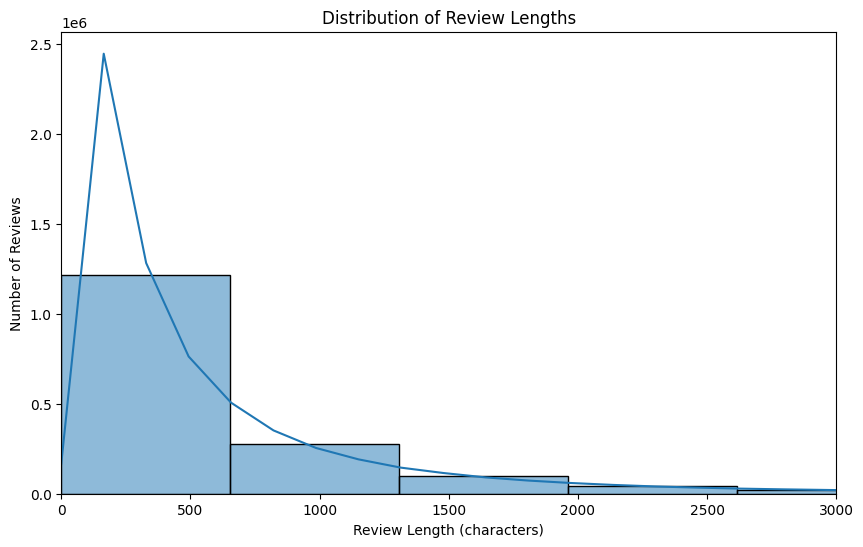

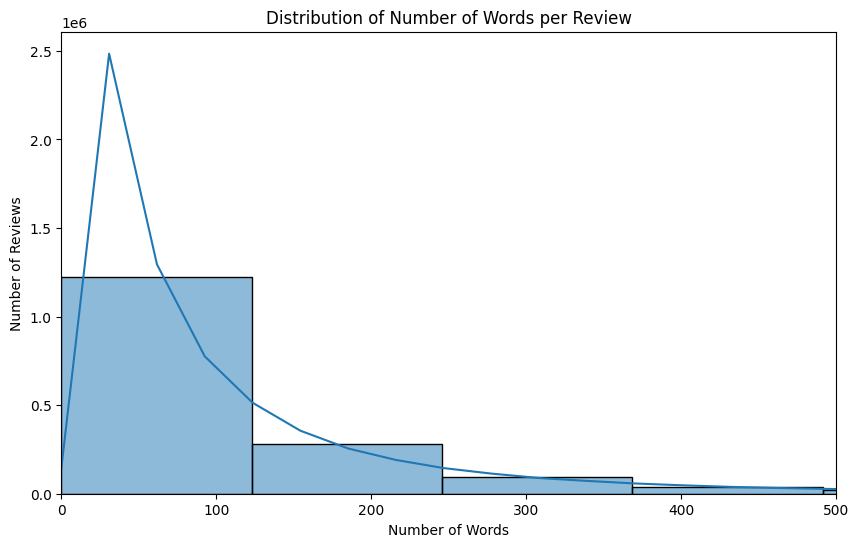

In [ ]:
# Plot the distributions
plt.figure(figsize=(10,6))
sns.histplot(reviews['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (characters)')
plt.ylabel('Number of Reviews')
plt.xlim(0, 3000)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(reviews['word_count'], bins=50, kde=True)
plt.title('Distribution of Number of Words per Review')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.xlim(0, 500)
plt.show()

## Truncation Method
We implement a flexible word-by-word truncation process to ensure that the word count remains largely within 150 words.

The reviews are split into words, and added one by one into a new truncated review. At 120 words, we allow early stopping at the first sentence end found. However, we also allow a few extra words to be added beyond 150 words until a natural sentence-ending punctuation mark is found. For unstructured reviews with no sentence ends, we make a hard stop at 150 words.

We want to ensure that reviews retrieved do not end prematurely mid-sentence, such that the extracted reviews remain natural for prompt and embedding quality.

In [ ]:
def truncate_review(text, max_words=150):
    if not isinstance(text, str):
        return ""

    words = text.split()

    # If short enough, return as-is
    if len(words) <= max_words:
        return text

    # Start adding words one by one
    truncated_text = ""
    word_count = 0

    for word in words:
        truncated_text += word + ' '
        word_count += 1

        # If we find a sentence end (., !, ?) and we have less than max_words, cut
        if word.endswith('.') or word.endswith('!') or word.endswith('?'):
            if word_count >= max_words * 0.8:  #	allow breaking early if we already have at least 80% of max_words
                break

    return truncated_text.strip()

In [ ]:
reviews['truncated_review'] = reviews['clean_reviewText'].apply(truncate_review)

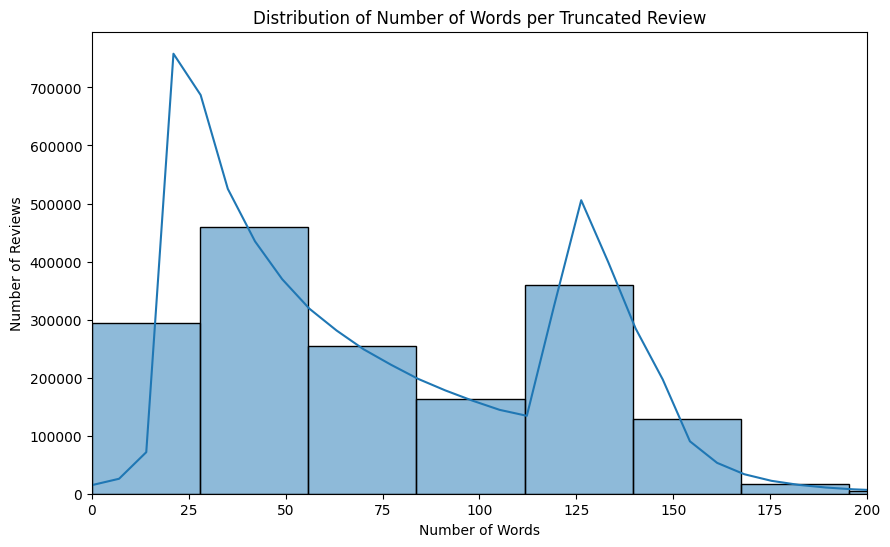

In [ ]:
# 1. Measure review length by number of words
reviews['truncated_word_count'] = reviews['truncated_review'].apply(lambda x: len(str(x).split()))

# 2. Plot the distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(reviews['truncated_word_count'], bins=50, kde=True)
plt.title('Distribution of Number of Words per Truncated Review')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.xlim(0, 200)  # you can adjust if needed
plt.show()

In [ ]:
pd.set_option('display.max_colwidth', None)
reviews[['truncated_review','reviewText','summary']].head(10)

truncated_review  \
0  We got this GPS for my husband who is an (OTR) over the road trucker. Very Impressed with the shipping time, it arrived a few days earlier than expected... within a week of use however it started freezing up... could of just been a glitch in that unit. Worked great when it worked! Will work great for the normal person as well but does have the "trucker" option. (the big truck routes - tells you when a scale is coming up ect...) Love the bigger screen, the ease of use, the ease of putting addresses into memory. Nothing really bad to say about the unit with the exception of it freezing which is probably one in a million and that's just my luck. I contacted the seller and within minutes of my email I received a email back with instructions for an exchange! VERY impressed all the way around!   
1                                                                                                     I'm a professional OTR truck driver, and I bought a TND 700 at a truck stop hoping to make my life easier. Rand McNally, are you listening?First thing I did after charging it was connect it to my laptop and install the software and then attempt to update it. The software detected a problem with my update and wanted my home address so I could be sent a patch on an SD card. Hello? I don't think I'm all that unusual; my home address is a PO box that a friend checks weekly and that I might get to check every six months or so. I live in my truck and at truck stops. If you need to make a patch available on an SD card then you should send the SD cards to the truck stops where the devices are sold.   
2                                                                                                                                                                      Well, what can I say. I've had this unit in my truck for about four days now. Prior to that I had a Garmin 755T non-truck GPS. One of my favorite features in that unit was the ability to plan a route by determining mileage using the stop or via feature. What I would do is using a map I would route myself several different ways forcing the unit by putting in stops or vias at different locations along the route, otherwise, like most GPS 's, it determines what it thinks is the best route. I could add up to 10 Via's or stop points for each route and then based on mileage and other factors determine which is the best route to take.   
3                                                                                     Not going to write a long review, even thought this unit deserves one. I've driven well over 1-mil miles and done most of my own routing so I pretty know whats the fastest and shortest. Have been using a basic garmin for the past three years and with ANY Gps unit they'll ALL get you in trouble if you let them. I was really excited about this unit, due to the size and the features. Allot of great grafics and on screen info thats usefull. But the most basic item that it was lacking was the gps tracking. I gave this unit allot of leadway on its mistakes due to the fact that it had allot of cool stuff that it did, but its ability to track you and route you was not even close to what the basic garmin could due.   
4                                                                                                I've had mine for a year and here's what we got. It tries to route be down non truck routes while telling me the truck route is illegal for me. This is such a bad problem that even Interstate 25 in Denver Colorado is listed (according to this GPS) as a non- truck route and will route you through the city instead. There are several drivers within our company who own one and more than half (of about 50) have crashed to an un-recoverable state. Our company representative said that Rand McNally informed them that the GPS was not designed to say on for a long period of time. Really? it's a truck driver GPS. We have one driver with a $2400 dollar ticket due to 

The summary will be concatenated with the review in case the truncated review misses out on key information or core ideas.

In [ ]:
reviews['embedding_input'] = "Summary: " + reviews['clean_summary'] + " Review: " + reviews['truncated_review']

In [ ]:
reviews.to_csv('/content/drive/My Drive/amazon_data/cleaned_reviews.csv', index = False)

# Embedding
We will be embedding the embedding input column using Sentence BERT to aid with RAG relevant reviews retrieval

In [ ]:
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer("all-MiniLM-L6-v2")
# review_embeddings = model.encode(reviews['embedding_input'].tolist(), batch_size=64, convert_to_numpy=True, show_progress_bar=True)
# np.savez(
#     '/content/drive/MyDrive/amazon_data/embeddings/review_embeddings.npz',
#     reviewer_ids=reviewer_ids,
#     asins=asins,
#     embeddings=review_embeddings
# )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]